In [12]:
# %% Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from pathlib import Path

In [13]:
# %% Function to load and filter dataset
def load_and_filter_dataset(file_path, dataset_name):
    """
    Load and filter a single dataset
    """
    print(f"\nProcessing {dataset_name}...")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    print(f"Initial dataset size: {len(df)} rows")
    
    # Remove rows where both contact_x and contact_y are 0
    df_filtered = df[~((df['contact_x'] == 0) & (df['contact_y'] == 0))].copy()
    df_filtered['contact_x'] = df_filtered['contact_x'] * 100 # convert in cm
    df_filtered['contact_y'] = df_filtered['contact_y'] * 100 # convert in cm
    df_filtered['position_x'] = df_filtered['position_x'] * 100 # convert in cm
    df_filtered['position_y'] = df_filtered['position_y'] * 100 # convert in cm
    # Calculate filtering statistics
    rows_removed = len(df) - len(df_filtered)
    percent_removed = (rows_removed / len(df)) * 100
    
    print(f"Removed {rows_removed} rows where contact_x and contact_y are both 0")
    print(f"Remaining dataset size: {len(df_filtered)} rows")
    print(f"Percentage of data removed: {percent_removed:.2f}%")
    
    return df_filtered, {
        'dataset_name': dataset_name,
        'original_rows': len(df),
        'filtered_rows': len(df_filtered),
        'rows_removed': rows_removed,
        'percent_removed': percent_removed,
        'unique_contacts': len(df_filtered[['contact_x', 'contact_y']].drop_duplicates())
    }

In [14]:
# %% Load and process all datasets
# Define the data directory path
base_path = Path('../../data/raw')

# Define dataset files
datasets = {
    'dataset1': base_path / 'ft_optitrack_data_pos1.csv',
    'dataset2': base_path / 'ft_optitrack_data_pos2.csv',
    'dataset3': base_path / 'ft_optitrack_data_pos3.csv'
}

# Process all datasets
filtered_datasets = {}
filtering_stats = []

for name, file_path in datasets.items():
    df_filtered, stats = load_and_filter_dataset(file_path, name)
    filtered_datasets[name] = df_filtered
    filtering_stats.append(stats)

# Create a summary DataFrame
summary_df = pd.DataFrame(filtering_stats)
print("\nSummary of all datasets:")
print(summary_df)

# Define grid size
grid_size = (12, 14)
max_distance = np.sqrt(12**2 + 14**2)


Processing dataset1...
Initial dataset size: 12978 rows
Removed 1387 rows where contact_x and contact_y are both 0
Remaining dataset size: 11591 rows
Percentage of data removed: 10.69%

Processing dataset2...
Initial dataset size: 13029 rows
Removed 1082 rows where contact_x and contact_y are both 0
Remaining dataset size: 11947 rows
Percentage of data removed: 8.30%

Processing dataset3...
Initial dataset size: 13015 rows
Removed 1156 rows where contact_x and contact_y are both 0
Remaining dataset size: 11859 rows
Percentage of data removed: 8.88%

Summary of all datasets:
  dataset_name  original_rows  filtered_rows  rows_removed  percent_removed  \
0     dataset1          12978          11591          1387        10.687317   
1     dataset2          13029          11947          1082         8.304551   
2     dataset3          13015          11859          1156         8.882059   

   unique_contacts  
0            11587  
1            11947  
2            11856  


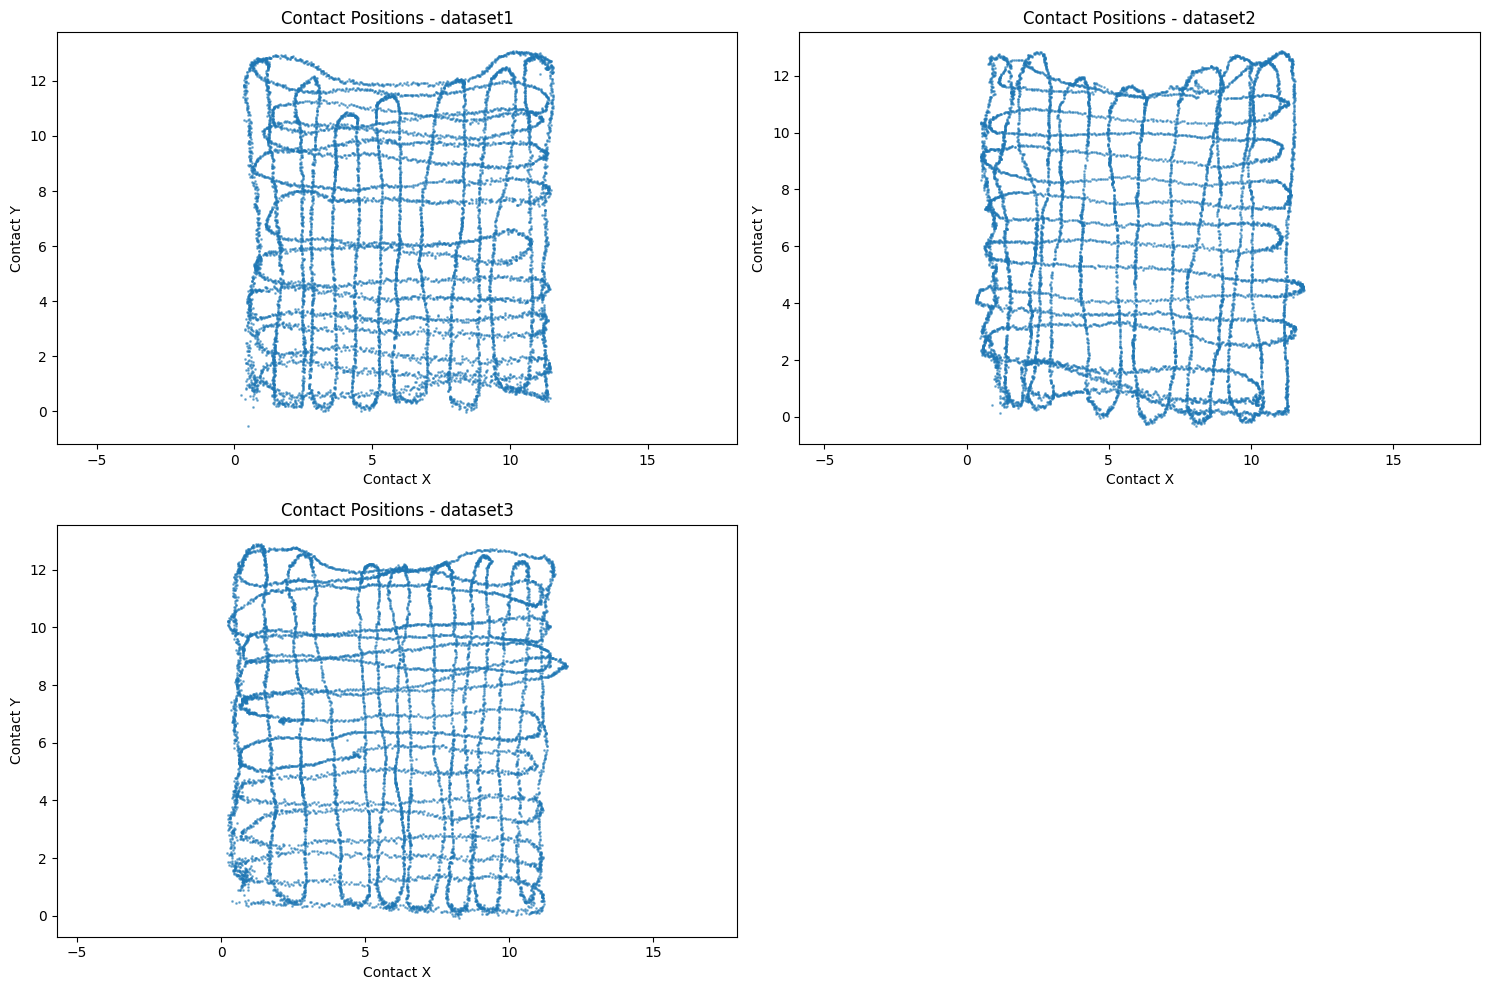

In [15]:
# %% Visualize contact positions for all datasets
plt.figure(figsize=(15, 10))
for idx, (name, df) in enumerate(filtered_datasets.items(), 1):
    plt.subplot(2, 2, idx)
    plt.scatter(df['contact_x'], df['contact_y'], alpha=0.5, s=1)
    plt.title(f'Contact Positions - {name}')
    plt.xlabel('Contact X')
    plt.ylabel('Contact Y')
    plt.axis('equal')

plt.tight_layout()
plt.show()

In [16]:
threshold = 4.0
# Calculate errors for each dataset
for name, df in filtered_datasets.items():
    # Calculate initial errors
    df['error_x'] = abs(df['contact_x'] - df['position_x'])
    df['error_y'] = abs(df['contact_y'] - df['position_y'])
    
    # Apply threshold and convert to NaN
    df['error_x'] = [x if x < threshold else np.nan for x in df['error_x']]
    df['error_y'] = [y if y < threshold else np.nan for y in df['error_y']]
    
    # Calculate error_norm before dropping NaN values
    mask = ~(df['error_x'].isna() | df['error_y'].isna())
    df['error_norm'] = np.nan  # Initialize with NaN
    df.loc[mask, 'error_norm'] = np.linalg.norm(df.loc[mask, ['error_x', 'error_y']].values, axis=1)
    
    # Calculate accuracy
    df['accuracy'] = 100 * (1 - np.minimum(df['error_norm'].fillna(max_distance) / max_distance, 1))
    
    # Drop NaN values and update the dictionary
    filtered_datasets[name] = df.dropna(subset=['error_x', 'error_y', 'error_norm'])

# Optional: Print statistics for each dataset
for name, df in filtered_datasets.items():
    print(f"\nDataset {name}:")
    print(f"Valid points: {len(df)}")
    print(f"Error range X: {df['error_x'].min():.2f} to {df['error_x'].max():.2f}")
    print(f"Error range Y: {df['error_y'].min():.2f} to {df['error_y'].max():.2f}")
    print(f"Error norm range: {df['error_norm'].min():.2f} to {df['error_norm'].max():.2f}")


Dataset dataset1:
Valid points: 11571
Error range X: 0.00 to 1.18
Error range Y: 0.01 to 1.30
Error norm range: 0.12 to 1.58

Dataset dataset2:
Valid points: 11947
Error range X: 0.00 to 1.41
Error range Y: 0.00 to 3.21
Error norm range: 0.02 to 3.24

Dataset dataset3:
Valid points: 11854
Error range X: 0.00 to 1.22
Error range Y: 0.00 to 2.81
Error norm range: 0.02 to 2.82


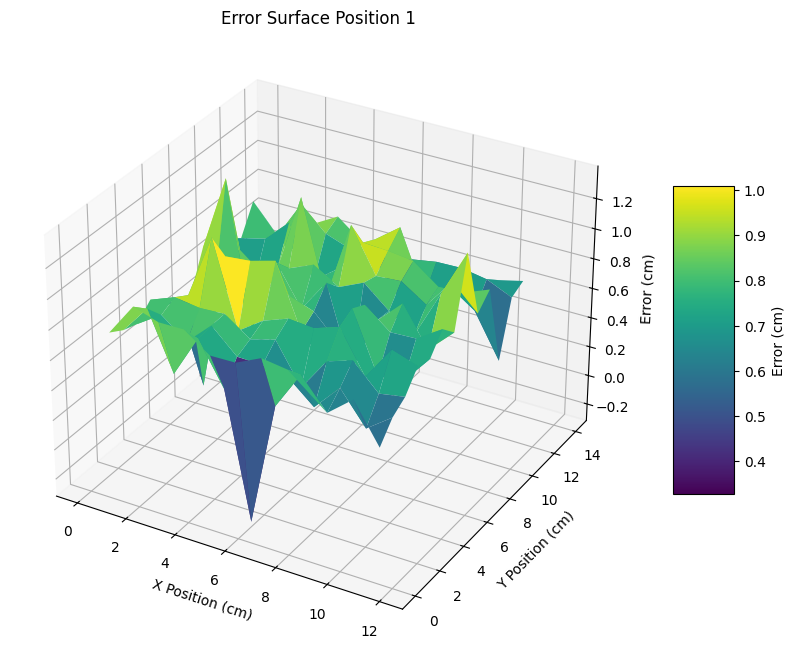

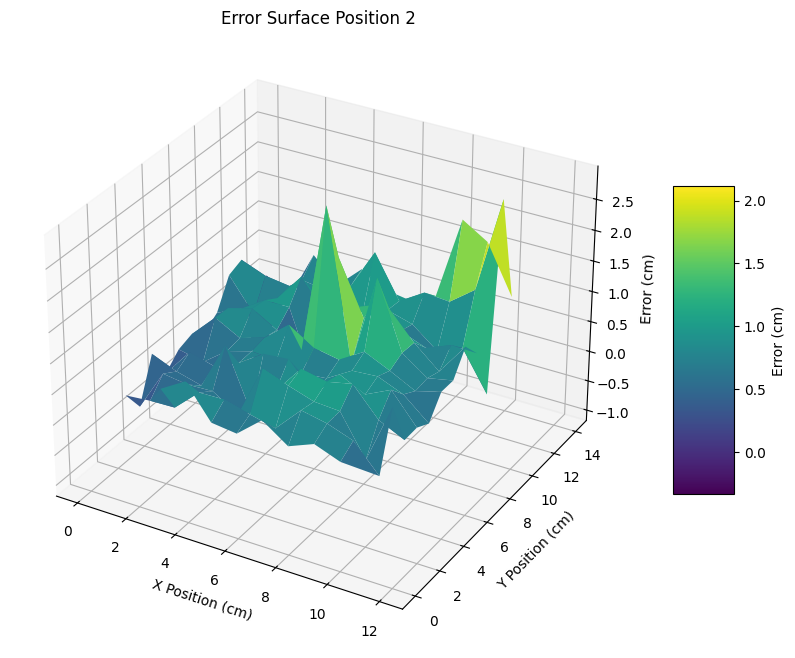

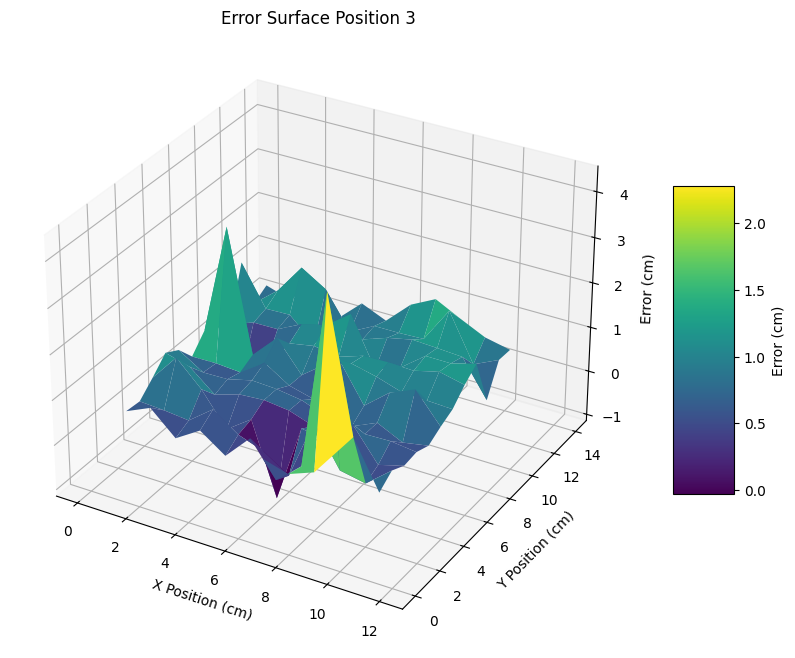

In [17]:
def plot_error_surface(df, grid_size, idx):
    
    xi = np.linspace(0, grid_size[0], grid_size[0]+1)
    yi = np.linspace(0, grid_size[1], grid_size[1]+1)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate errors onto regular grid
    zi = griddata((df['contact_x'], df['contact_y']), 
                  df['error_norm'], 
                  (xi, yi), 
                  method='cubic',
                  fill_value=np.nan)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(xi, yi, zi, 
                          cmap='viridis',
                          linewidth=0,
                          antialiased=True)
    
    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Error (cm)')
    
    # Labels and title
    ax.set_xlabel('X Position (cm)')
    ax.set_ylabel('Y Position (cm)')
    ax.set_zlabel('Error (cm)')
    ax.set_title(f"Error Surface Position {idx}")
    
    return fig, ax

# Create and show the plot
for idx, (name, df) in enumerate(filtered_datasets.items(), 1):
    fig, ax = plot_error_surface(df, grid_size, idx)
    #fig.savefig(f"error_plot_{idx}.png", dpi=600, bbox_inches='tight', format='png')
    plt.show()

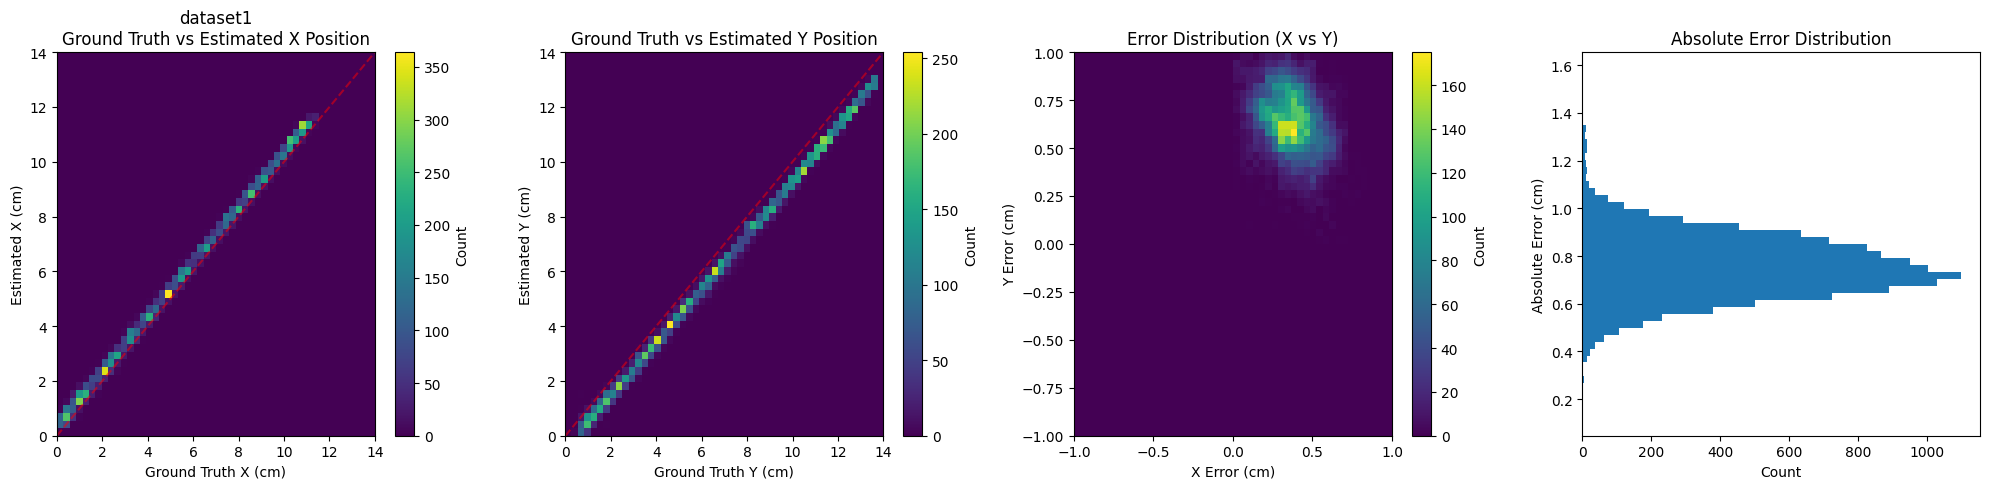


Error Statistics for dataset1:
Mean X Error: 0.3602 ± 0.1319 cm
Mean Y Error: 0.6444 ± 0.1560 cm
Mean Absolute Error: 0.7547 cm
Median Absolute Error: 0.7492 cm
RMSE X: 0.3836 cm
RMSE Y: 0.6630 cm
Accuracy: 95.9073 %


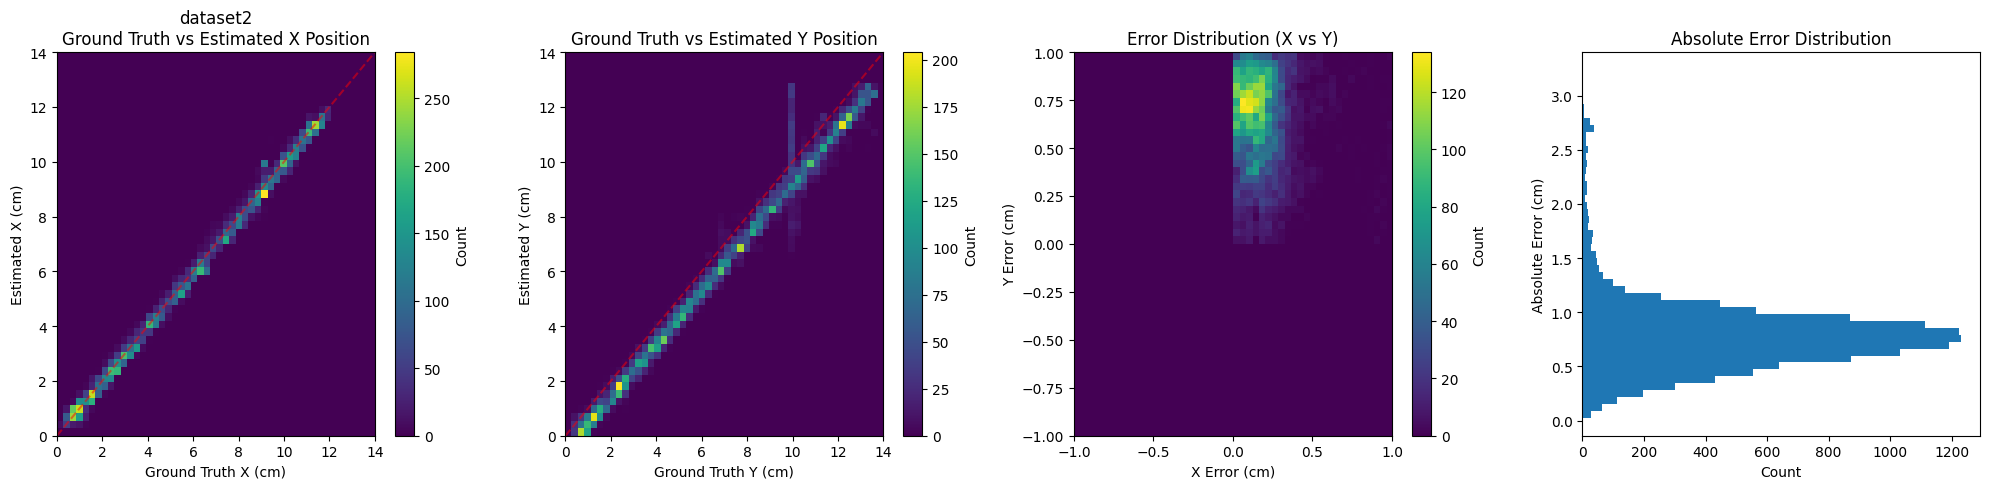


Error Statistics for dataset2:
Mean X Error: 0.1808 ± 0.1450 cm
Mean Y Error: 0.7506 ± 0.3599 cm
Mean Absolute Error: 0.7864 cm
Median Absolute Error: 0.7584 cm
RMSE X: 0.2317 cm
RMSE Y: 0.8324 cm
Accuracy: 95.7350 %


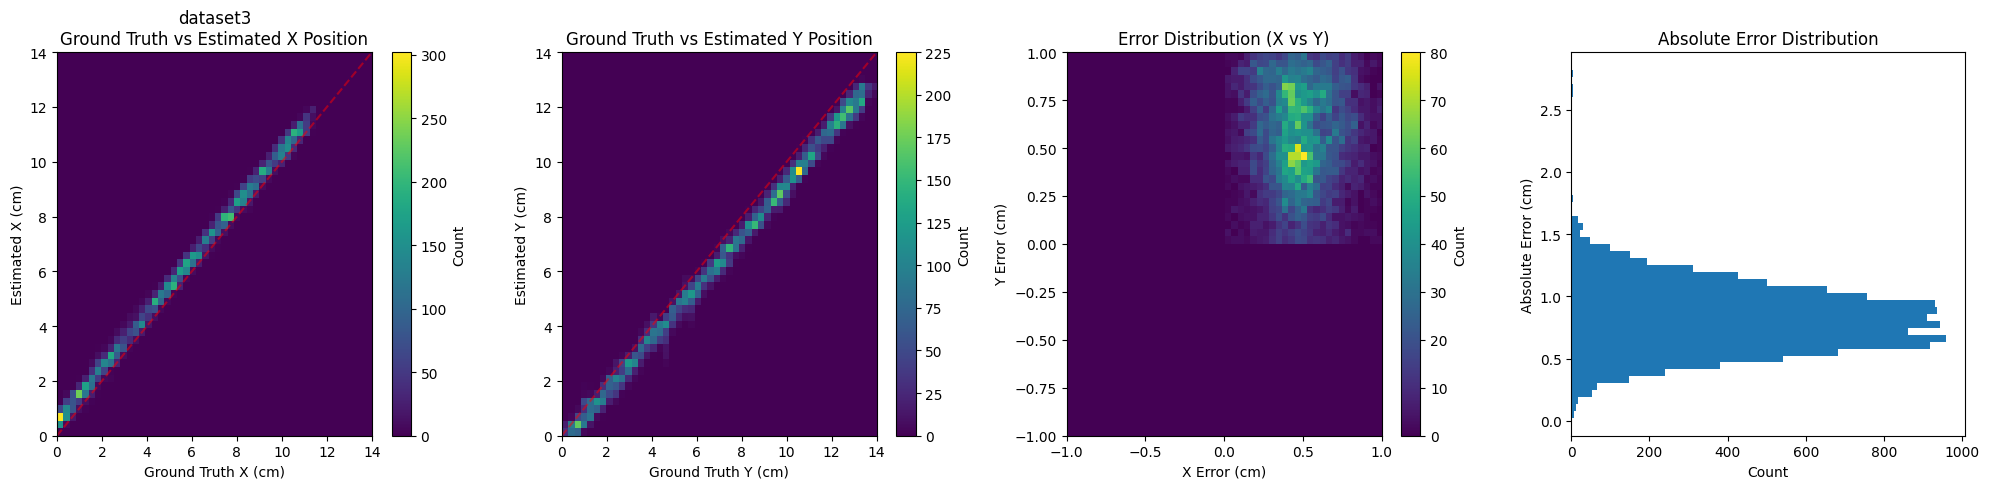


Error Statistics for dataset3:
Mean X Error: 0.4781 ± 0.1921 cm
Mean Y Error: 0.6228 ± 0.3065 cm
Mean Absolute Error: 0.8223 cm
Median Absolute Error: 0.8117 cm
RMSE X: 0.5153 cm
RMSE Y: 0.6941 cm
Accuracy: 95.5404 %

Comparative Error Statistics:
    dataset  rmse_x  rmse_y  mean_abs_error  median_abs_error  max_abs_error  \
0  dataset1  0.3836  0.6630          0.7547            0.7492         1.5819   
1  dataset2  0.2317  0.8324          0.7864            0.7584         3.2399   
2  dataset3  0.5153  0.6941          0.8223            0.8117         2.8222   

   mean_accuracy  
0        95.9073  
1        95.7350  
2        95.5404  


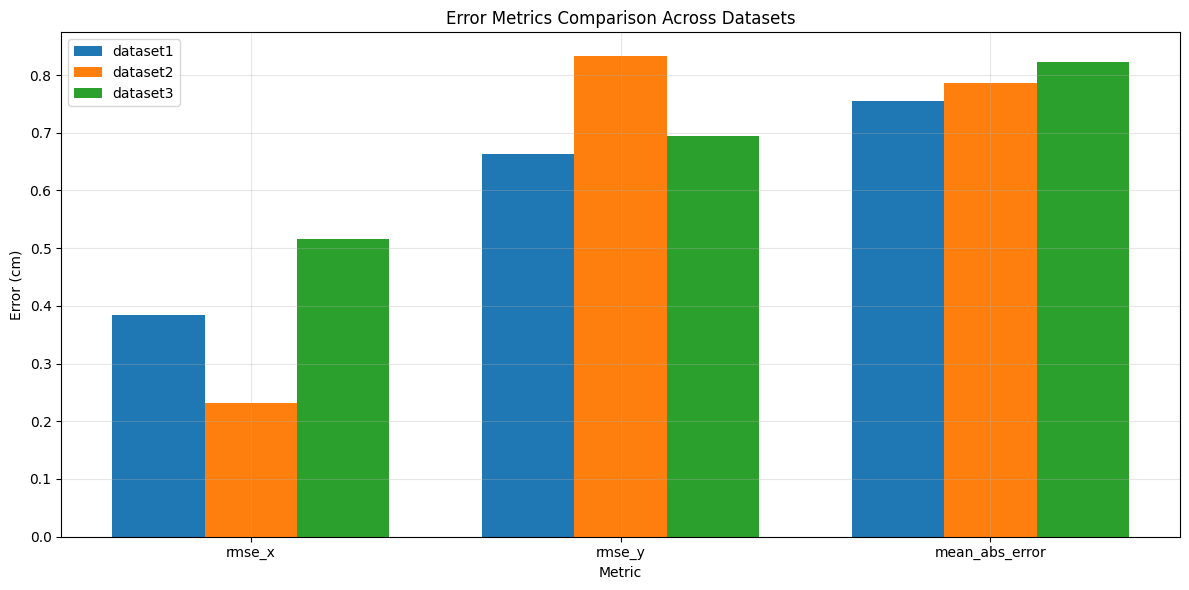

In [18]:
def create_position_error_heatmap(filtered_datasets):
    """
    Create heatmaps comparing ground truth and estimated positions for all datasets
    """
    for name, df in filtered_datasets.items():
        
        # Create figure with multiple subplots
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # 1. Heatmap of ground truth vs estimated X position
        counts, xedges, yedges = np.histogram2d(
            df['position_x'], df['contact_x'],
            bins=50, 
            range=[[0.0, 14.0], [0.0, 14.0]]
        )
        im1 = axes[0].imshow(counts.T, origin='lower', 
                           extent=[0.0, 14.0, 0.0, 14.0],
                           aspect='auto', cmap='viridis')
        plt.colorbar(im1, ax=axes[0], label='Count')
        axes[0].plot([0.0, 14.0], [0.0, 14.0], 'r--', alpha=0.5)
        axes[0].set_xlabel('Ground Truth X (cm)')
        axes[0].set_ylabel('Estimated X (cm)')
        axes[0].set_title(f'{name}\nGround Truth vs Estimated X Position')
        
        # 2. Heatmap of ground truth vs estimated Y position
        counts, xedges, yedges = np.histogram2d(
            df['position_y'], df['contact_y'],
            bins=50, 
            range=[[0.0, 14.0], [0.0, 14.0]]
        )
        im2 = axes[1].imshow(counts.T, origin='lower', 
                           extent=[0.0, 14.0, 0.0, 14.0],
                           aspect='auto', cmap='viridis')
        plt.colorbar(im2, ax=axes[1], label='Count')
        axes[1].plot([0.0, 14.0], [0.0, 14.0], 'r--', alpha=0.5)
        axes[1].set_xlabel('Ground Truth Y (cm)')
        axes[1].set_ylabel('Estimated Y (cm)')
        axes[1].set_title('Ground Truth vs Estimated Y Position')
        
        # 3. 2D error distribution
        counts, xedges, yedges = np.histogram2d(
            df['error_x'], df['error_y'],
            bins=50, 
            range=[[-1.0, 1.0], [-1.0, 1.0]]
        )
        im3 = axes[2].imshow(counts.T, origin='lower', 
                           extent=[-1.0, 1.0, -1.0, 1.0],
                           aspect='auto', cmap='viridis')
        plt.colorbar(im3, ax=axes[2], label='Count')
        axes[2].set_xlabel('X Error (cm)')
        axes[2].set_ylabel('Y Error (cm)')
        axes[2].set_title('Error Distribution (X vs Y)')
        
        # 4. Absolute position error distribution
        axes[3].hist(df['error_norm'], bins=50, orientation='horizontal')
        axes[3].set_ylabel('Absolute Error (cm)')
        axes[3].set_xlabel('Count')
        axes[3].set_title('Absolute Error Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Print error statistics
        print(f"\nError Statistics for {name}:")
        print(f"Mean X Error: {df['error_x'].mean():.4f} ± {df['error_x'].std():.4f} cm")
        print(f"Mean Y Error: {df['error_y'].mean():.4f} ± {df['error_y'].std():.4f} cm")
        print(f"Mean Absolute Error: {df['error_norm'].mean():.4f} cm")
        print(f"Median Absolute Error: {df['error_norm'].median():.4f} cm")
        print(f"RMSE X: {np.sqrt((df['error_x']**2).mean()):.4f} cm")
        print(f"RMSE Y: {np.sqrt((df['error_y']**2).mean()):.4f} cm")
        print(f"Accuracy: {df['accuracy'].mean():.4f} %")

def create_error_summary(filtered_datasets):
    """
    Create summary statistics for all datasets
    """
    error_stats = []
    
    for name, df in filtered_datasets.items():
        
        stats = {
            'dataset': name,
            'rmse_x': np.sqrt((df['error_x']**2).mean()),
            'rmse_y': np.sqrt((df['error_y']**2).mean()),
            'mean_abs_error': df['error_norm'].mean(),
            'median_abs_error': df['error_norm'].median(),
            'max_abs_error': df['error_norm'].max(),
            'mean_accuracy': df['accuracy'].mean()
        }
        error_stats.append(stats)
    
    # Create and save summary DataFrame
    error_stats_df = pd.DataFrame(error_stats)
    processed_dir = Path('../../data/processed')
    processed_dir.mkdir(parents=True, exist_ok=True)
    error_stats_df.to_csv(processed_dir / 'position_error_statistics.csv', index=False)
    
    return error_stats_df

# Create heatmaps and error analysis
create_position_error_heatmap(filtered_datasets)

# Create and display error summary
error_stats_df = create_error_summary(filtered_datasets)
print("\nComparative Error Statistics:")
print(error_stats_df.round(4))

# Create comparative bar plot
plt.figure(figsize=(12, 6))
metrics = ['rmse_x', 'rmse_y', 'mean_abs_error']
x = np.arange(len(metrics))
width = 0.25

for i, dataset in enumerate(error_stats_df['dataset']):
    plt.bar(x + i*width, 
           error_stats_df.loc[error_stats_df['dataset'] == dataset, metrics].values[0], 
           width, 
           label=dataset)


    
plt.xlabel('Metric')
plt.ylabel('Error (cm)')
plt.title('Error Metrics Comparison Across Datasets')
plt.xticks(x + width, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('error_metrics_comparison.png', dpi=600, bbox_inches='tight', format='png')

plt.show()





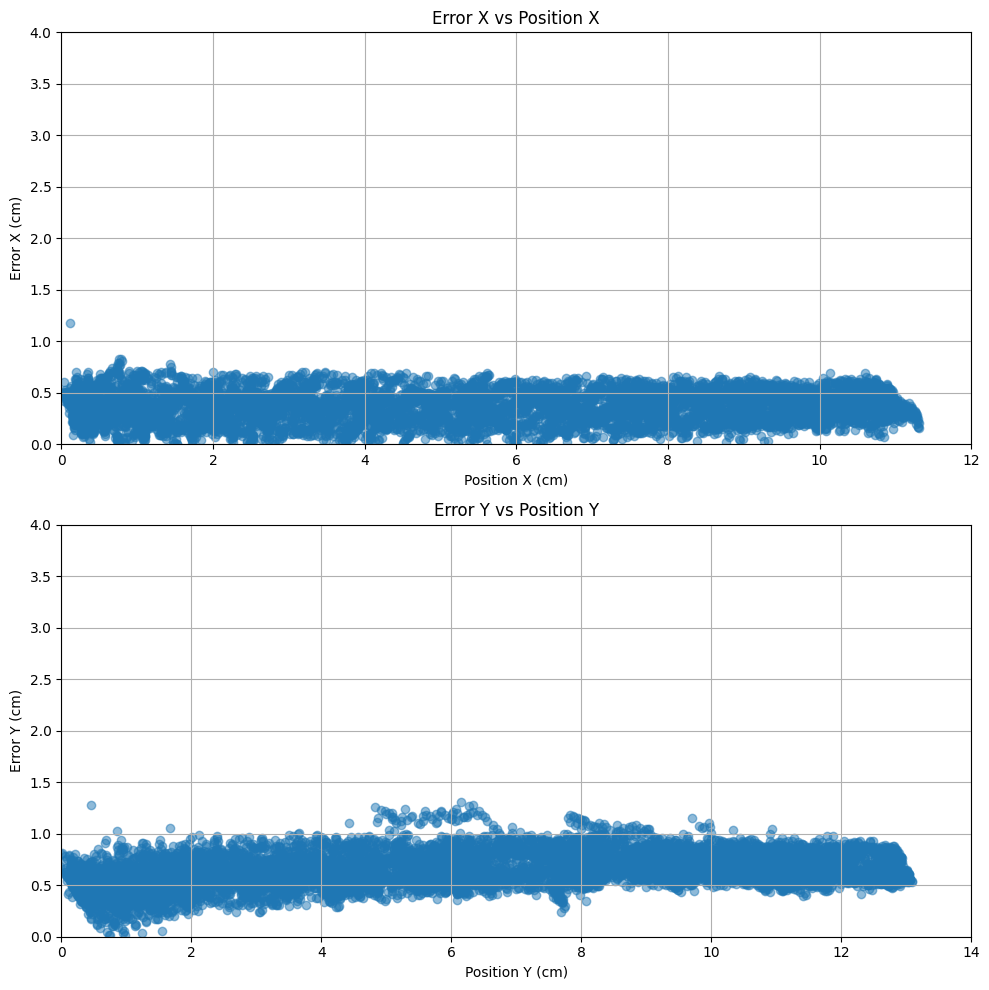

X position-error correlation: 0.085
Y position-error correlation: 0.414


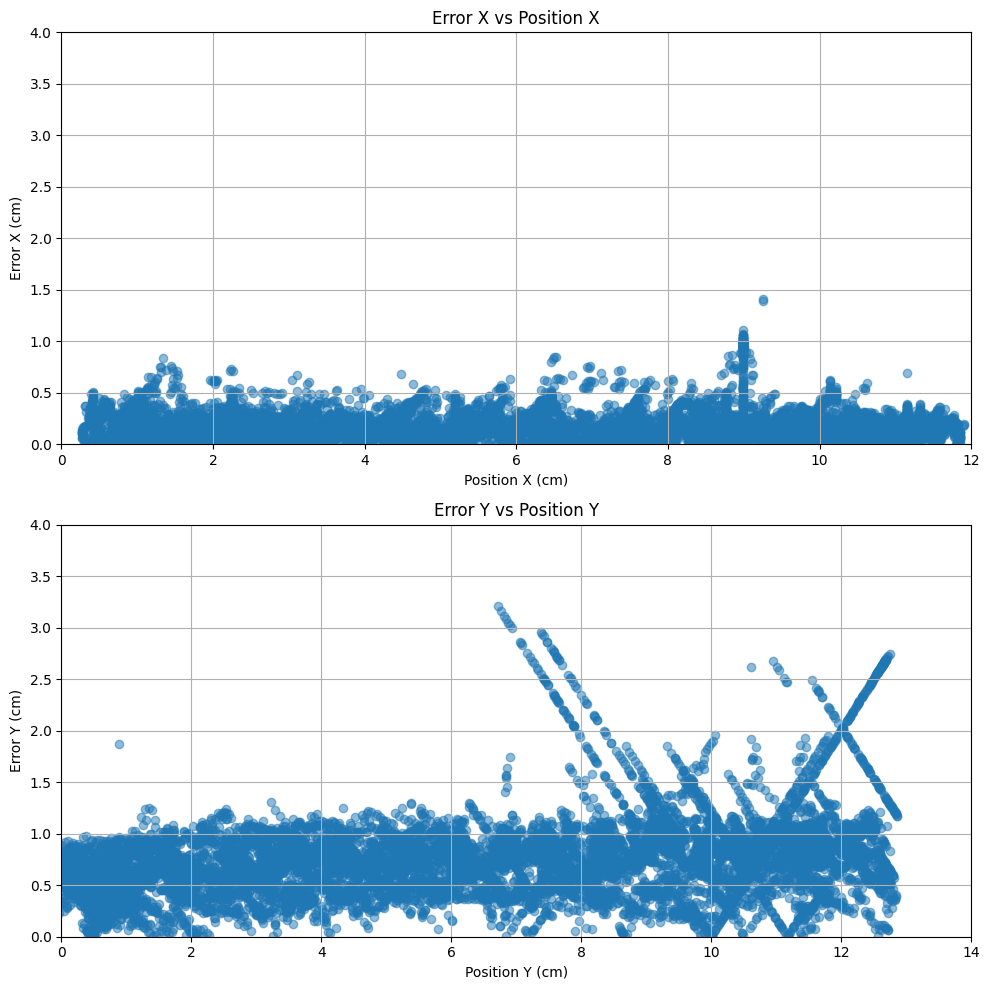

X position-error correlation: 0.044
Y position-error correlation: 0.324


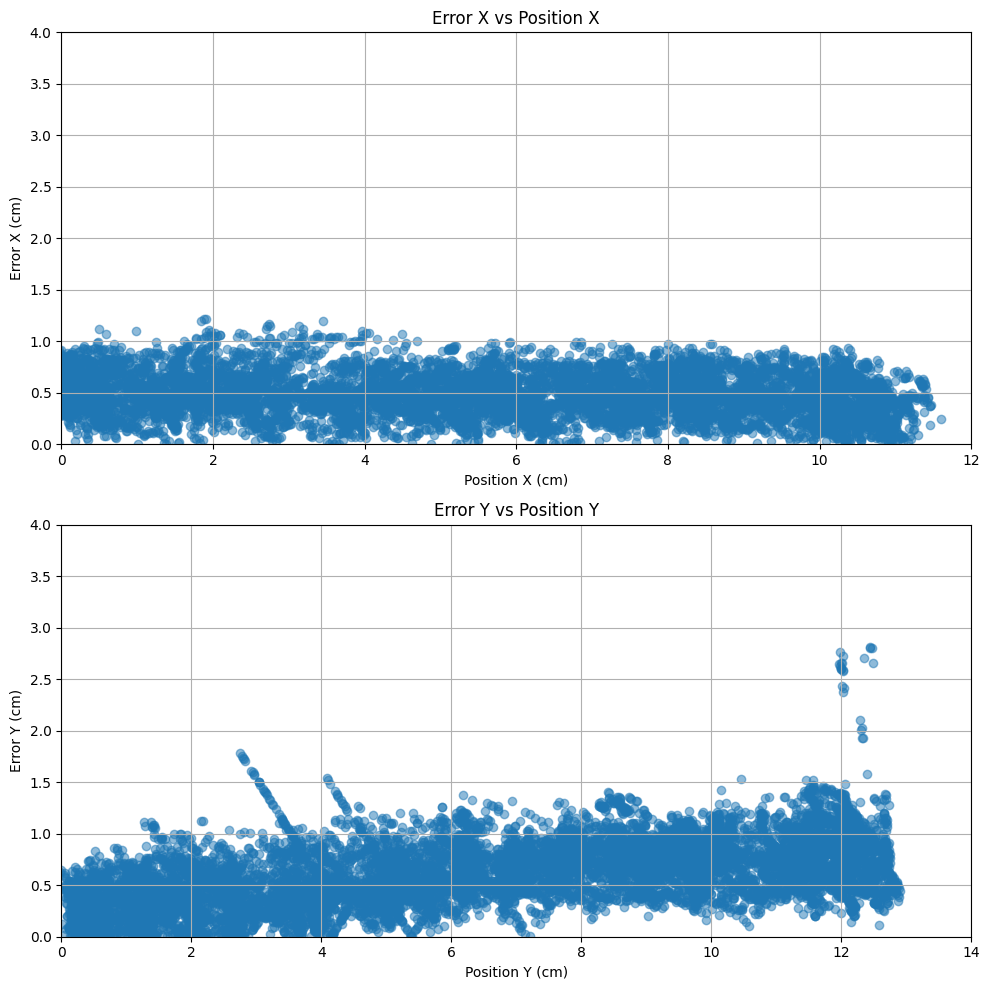

X position-error correlation: -0.145
Y position-error correlation: 0.547


In [24]:
for idx, (name, df) in enumerate(filtered_datasets.items(), 1):
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    # Create interpolated points for smoother trajectory
    x_positions = df['position_x']
    y_positions = df['contact_y']
    x_errors = df['error_x']
    y_errors = df['error_y']
    
    # Plot error_x based on position_x
    axes[0].scatter(x_positions, x_errors, alpha=0.5)
    axes[0].set_xlabel('Position X (cm)')
    axes[0].set_ylabel('Error X (cm)')
    axes[0].set_title('Error X vs Position X')
    axes[0].grid(True)
    axes[0].set_xlim(0, 12)
    axes[0].set_ylim(0, threshold)
    
    # Plot error_y based on contact_y
    axes[1].scatter(y_positions, y_errors, alpha=0.5)
    axes[1].set_xlabel('Position Y (cm)')
    axes[1].set_ylabel('Error Y (cm)')
    axes[1].set_title('Error Y vs Position Y')
    axes[1].grid(True)
    axes[1].set_xlim(0, 14)
    axes[1].set_ylim(0, threshold)

    plt.tight_layout()

    fig.savefig(f"error_contact_{idx}.png", dpi=600, bbox_inches='tight', format='png')

    plt.show()

    # Calculate correlations between positions and errors
    x_correlation = x_positions.corr(x_errors)
    y_correlation = y_positions.corr(y_errors)

    print(f"X position-error correlation: {x_correlation:.3f}")
    print(f"Y position-error correlation: {y_correlation:.3f}")



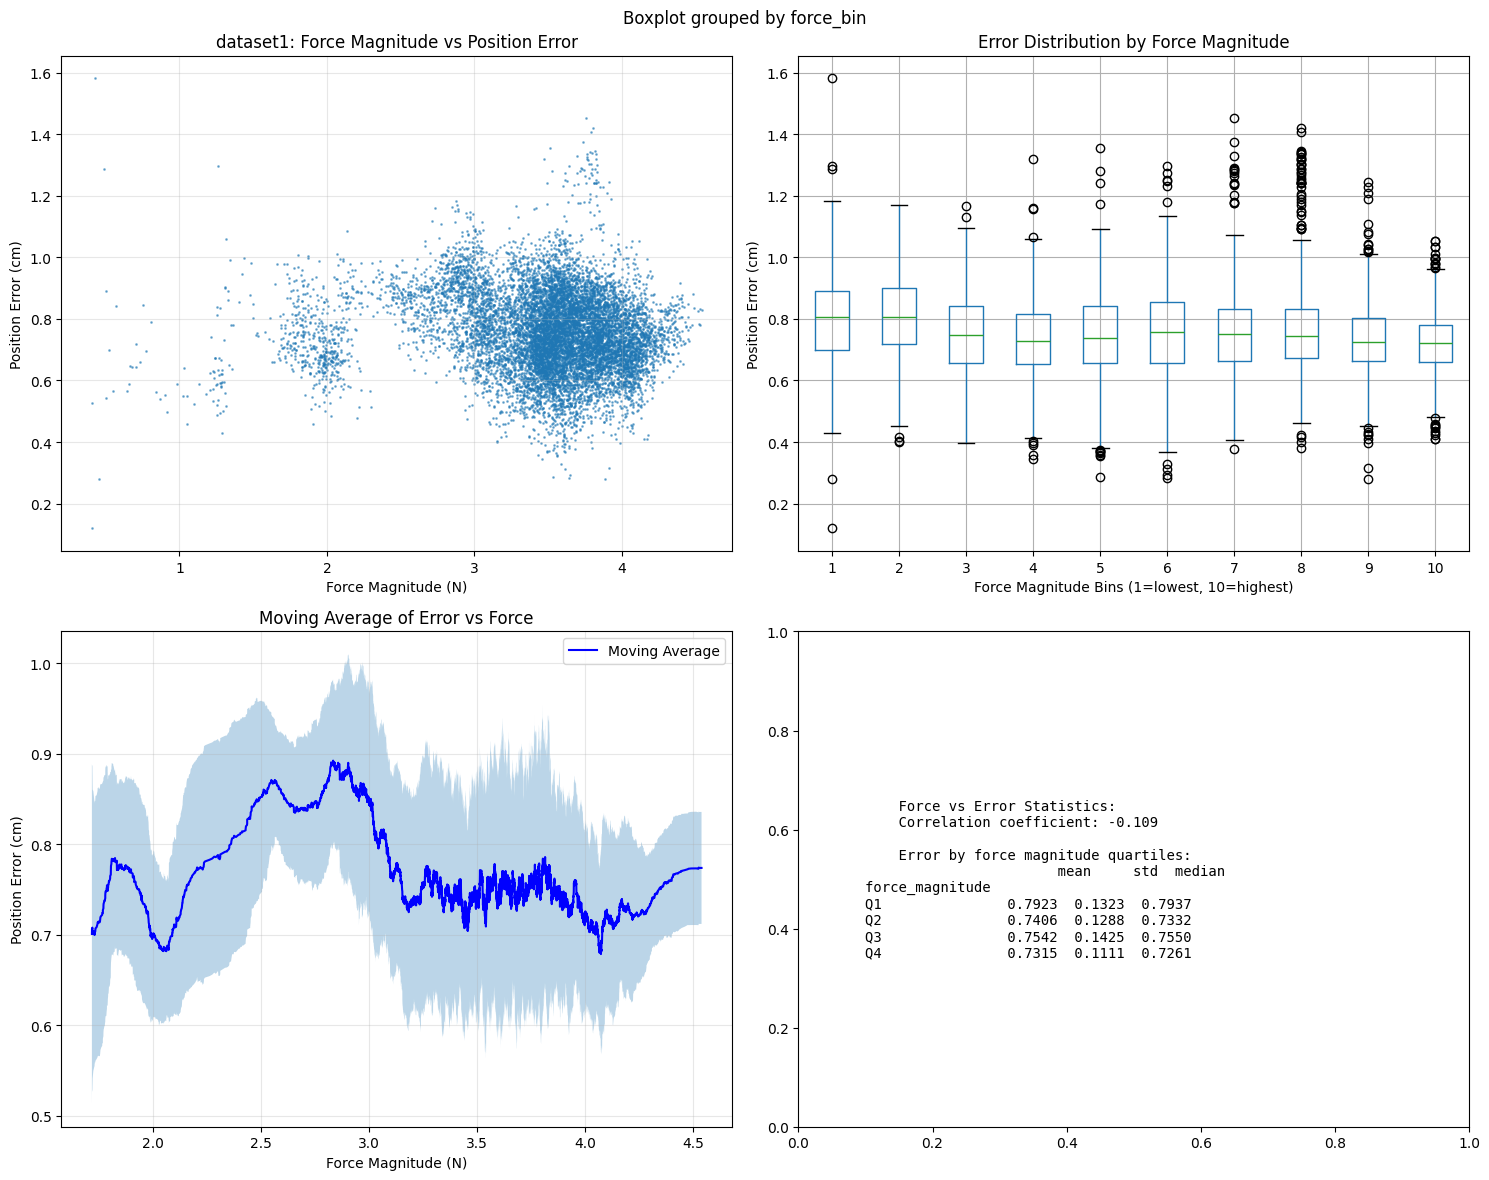

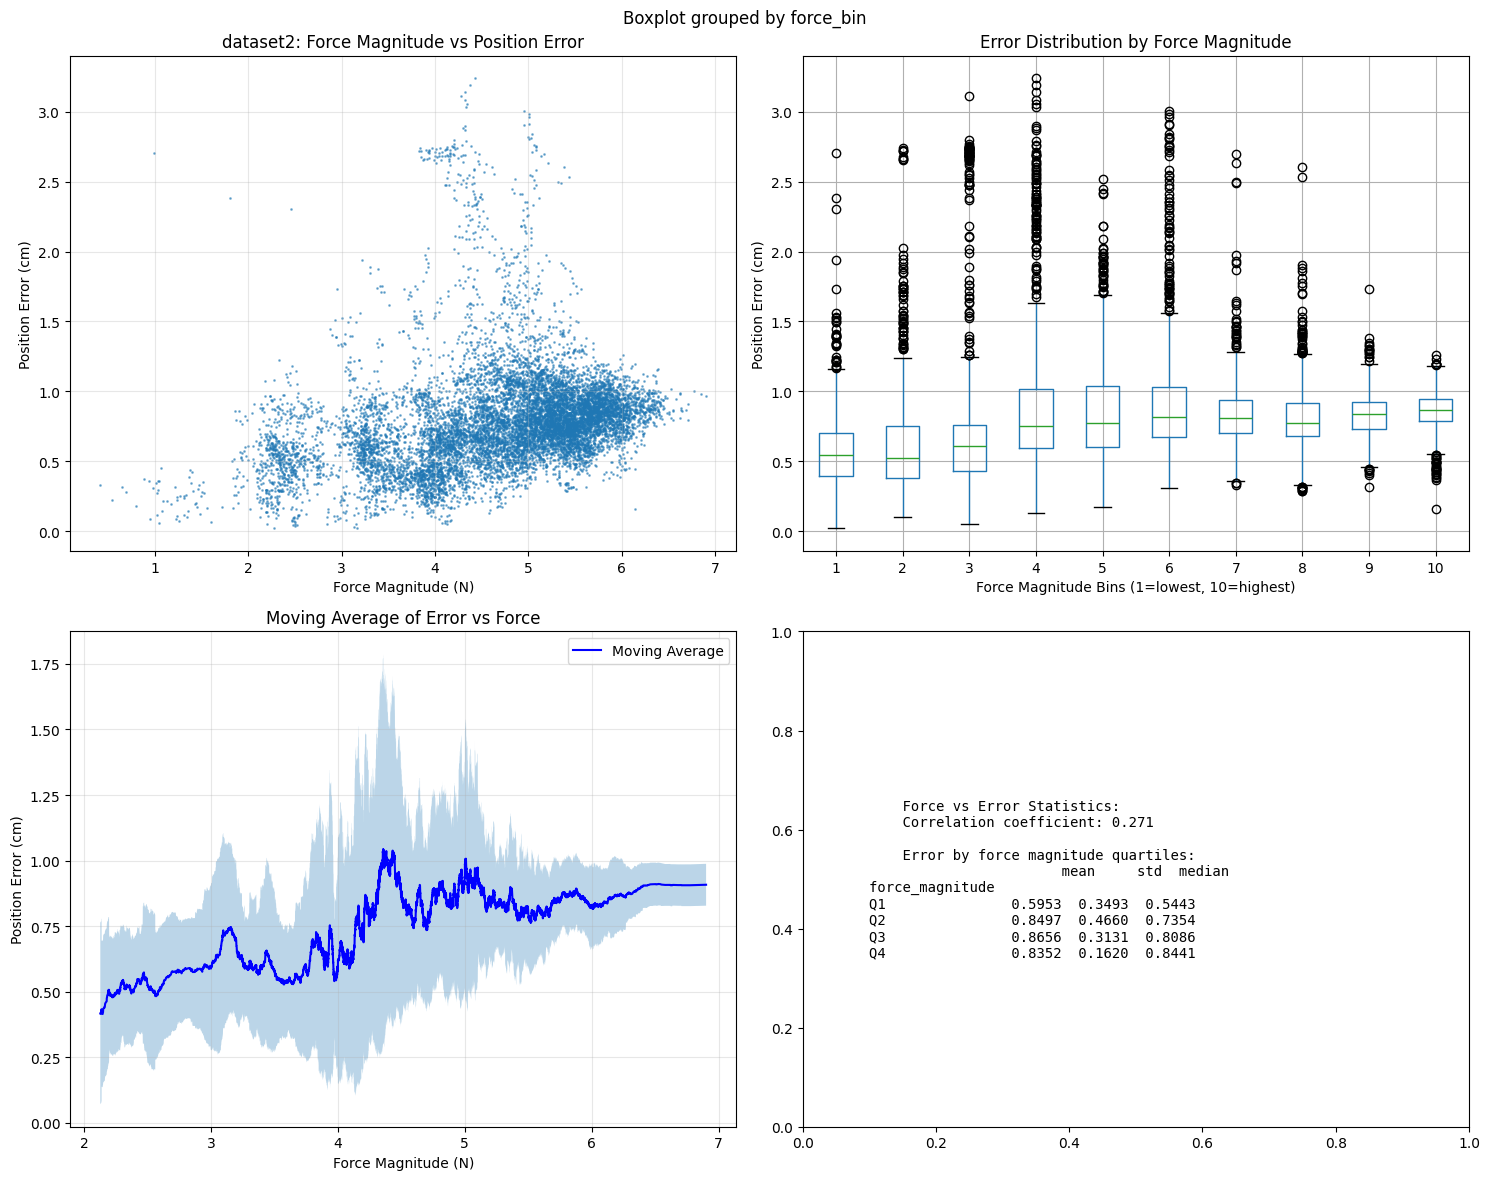

/tmp/ipykernel_8756/860721713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['force_magnitude'] = np.sqrt(df['force_x']**2 + df['force_y']**2 + df['force_z']**2)


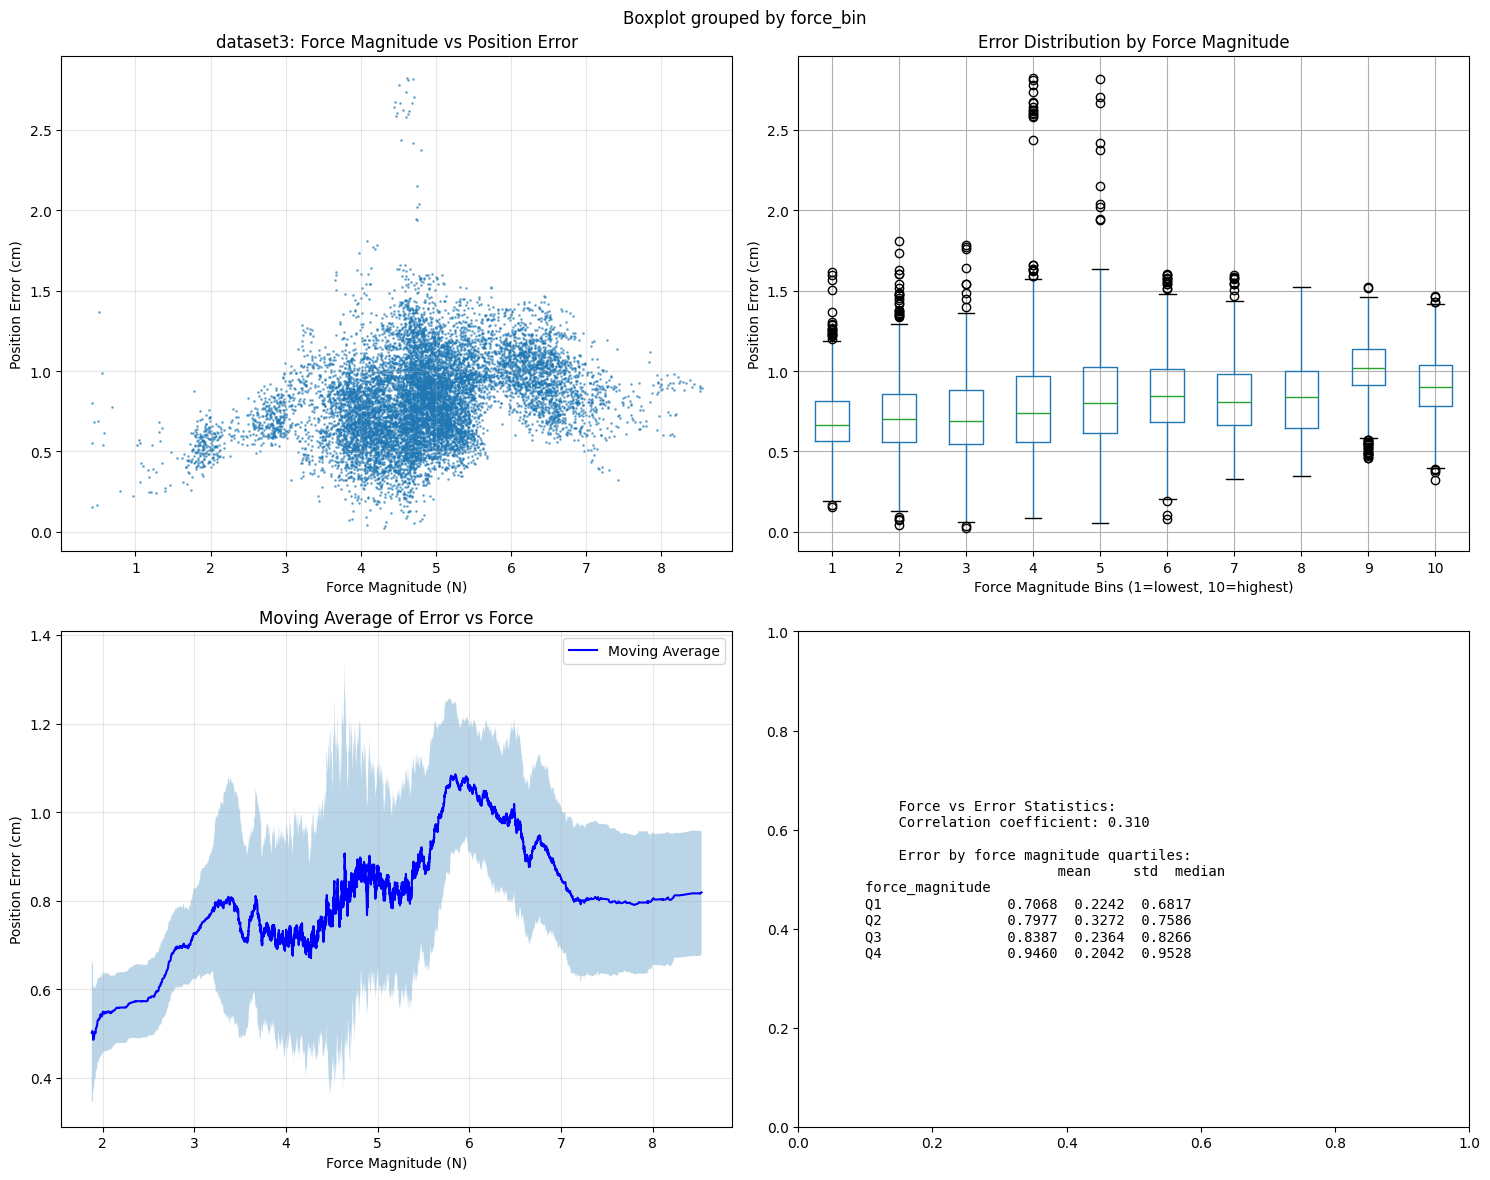

In [20]:
#Analyze how positioning errors correlate with applied force magnitude

for name, df in filtered_datasets.items():
    # Calculate force magnitude
    df['force_magnitude'] = np.sqrt(df['force_x']**2 + df['force_y']**2 + df['force_z']**2)
    
    # Sort by force magnitude
    df_sorted = df.sort_values('force_magnitude')
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot of force magnitude vs absolute error
    axes[0,0].scatter(df_sorted['force_magnitude'], df_sorted['error_norm'], 
                        alpha=0.5, s=1)
    axes[0,0].set_xlabel('Force Magnitude (N)')
    axes[0,0].set_ylabel('Position Error (cm)')
    axes[0,0].set_title(f'{name}: Force Magnitude vs Position Error')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot of errors binned by force magnitude
    # Create force magnitude bins
    n_bins = 10
    df_sorted['force_bin'] = pd.qcut(df_sorted['force_magnitude'], n_bins, 
                                    labels=[f'{i+1}' for i in range(n_bins)])
    
    df_sorted.boxplot(column='error_norm', by='force_bin', ax=axes[0,1])
    axes[0,1].set_xlabel('Force Magnitude Bins (1=lowest, 10=highest)')
    axes[0,1].set_ylabel('Position Error (cm)')
    axes[0,1].set_title('Error Distribution by Force Magnitude')
    
    # 3. Moving average of error vs force magnitude
    window_size = len(df_sorted) // 100  # Use 1% of data points as window
    rolling_mean = df_sorted['error_norm'].rolling(window=window_size).mean()
    rolling_std = df_sorted['error_norm'].rolling(window=window_size).std()
    
    axes[1,0].plot(df_sorted['force_magnitude'], rolling_mean, 'b-', 
                    label='Moving Average')
    axes[1,0].fill_between(df_sorted['force_magnitude'],
                            rolling_mean - rolling_std,
                            rolling_mean + rolling_std,
                            alpha=0.3)
    axes[1,0].set_xlabel('Force Magnitude (N)')
    axes[1,0].set_ylabel('Position Error (cm)')
    axes[1,0].set_title('Moving Average of Error vs Force')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend()
    
    # 4. Calculate and plot error statistics for each force bin
    bin_stats = df_sorted.groupby('force_bin', observed=True).agg({
        'error_norm': ['mean', 'std', 'median'],
        'force_magnitude': 'mean'
    }).reset_index()
    
    bin_stats.columns = ['bin', 'mean_error', 'std_error', 'median_error', 'mean_force']
    
    # Correlation analysis
    correlation = df_sorted['force_magnitude'].corr(df_sorted['error_norm'])
    
    # Quartile statistics
    quartile_stats = df_sorted.groupby(
        pd.qcut(df_sorted['force_magnitude'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4']),
        observed=True
    )['error_norm'].agg([
        'mean', 'std', 'median'
    ]).round(4)

    # Print statistics
    stats_text = f"""
    Force vs Error Statistics:
    Correlation coefficient: {correlation:.3f}
    
    Error by force magnitude quartiles:
    {quartile_stats}
    """
    axes[1,1].text(0.1, 0.5, stats_text, transform=axes[1,1].transAxes,
                    verticalalignment='center', fontfamily='monospace')
    
    plt.tight_layout()
    
    #fig.savefig(f"error_force.png", dpi=600, bbox_inches='tight', format='png')

    plt.show()